In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


추후 Feature Enginnering에 이용될 계산 함수 정의

In [3]:
###### ACC
# 가속도 벡터 magnitude 계산 함수
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = np.sqrt(acc_x ** 2 + acc_y ** 2 + acc_z ** 2)
    return acc_mag

###### Activity bouts
def exercisepts(acc, hr, time): #acc and hr must be same length, acc must be magnitude
    """
        calculates activity bouts using accelerometry and heart rate
        Args:
            acc (pandas.DataFrame column or pandas series): accelerometry column
            hr (pandas.DataFrame column or pandas series): heart rate column
            time (pandas.DataFrame column or pandas series): time column
        Returns:
            countbouts (IntegerType): the number of acitvity bouts total
            returndf (pandas.DataFrame): a pandas dataframe with time and activity bouts (designated as a '1') to easily integrate with your data workflow
    """  
    
    exercisepoints = []
    for z in range(len(acc)):
        if acc.iloc[z] > np.mean(acc.iloc[0:z]):
            if hr.iloc[z] > np.mean(hr.iloc[0:z]):
                exercisepoints.append(1)
            else:
                exercisepoints.append(0)
        else:
            exercisepoints.append(0)
            
    returndf = pd.DataFrame()
    returndf['datetime'] = time
    returndf['Activity Bouts'] = exercisepoints
    
    countbouts = len(exercisepoints)
    return countbouts, returndf

###### EDA
def peak_eda(eda):
    peaks_idx, properties = find_peaks(eda, height=0, distance=4, prominence=0.3)
    peak_eda = len(peaks_idx)
    return peak_eda

'''
# rolling window에서 피크를 찾는 함수
def find_peaks_in_rolling_window(data, window_size):
    number_of_windows = 0
    peaks_in_window = 0
    for window_data in data.rolling(window=window_size):
        peaks, _ = find_peaks(window_data[' eda'], height=0, distance=4, prominence=0.3)
        if peaks.any():
            peaks_in_window += len(peaks)
        number_of_windows += 1
    return number_of_windows, peaks_in_window
'''

# PersHigh, PersLow, PersNorm 분류 함수
def classify_glucose(value, mean, std):
    if value > mean + std:
        return 'PersHigh'
    elif value < mean - std:
        return 'PersLow'
    else:
        return 'PersNorm'
    
###### IBI
def nn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    nn50 = round(n,1)
    return nn50

def pnn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    p=0
    if len(differences) != 0:
        p = (n / len(differences)) * 100
    pnn50 = round(p, 1)
    return pnn50

def rmssd(ibi):
    differences = abs(np.diff(ibi))
    rmssd = 0
    if len(differences) != 0:
        rmssd = np.sqrt(np.sum(np.square(differences)) / len(differences))
    rmssd = round(rmssd,1)
    return rmssd

def sdnn(ibi):
    if ibi.isnull().any():
        return np.nan
    #return round(np.sqrt(np.var(ibi, ddof=1)) * 10) / 10
    return round(np.sqrt(np.var(ibi, ddof=1)), 1)

###### circaidan rhythm
def crhythm(time, timeformat='%Y-%m-%d %H:%M:%S'):
    """
        computes 'minutes from midnight' and 'hours from midnight'- these features will allow you to account for circaidan rhythm effects
        Args:
             time (pandas.DataFrame): time column
             timeformat (String): default = '%Y-%m-%d %H:%M:%S.%f'; format of timestamp in time column
        Returns:
            hourfrommid (ListType): Hours from midnight, the same length as your time column
            minfrommid (ListType): Minutes from midnight, the same length as your time column

    """
    
    df = pd.DataFrame()
    df['Time'] =  pd.to_datetime(time, format=timeformat)
    df['Timefrommidnight'] =  df['Time'].dt.time
    hourfrommid=[]
    minfrommid=[]
    
    for i in range(0, len(df['Timefrommidnight'])):
        if pd.isna(df['Timefrommidnight'].iloc[i]):
            minfrommid.append(0)
            hourfrommid.append(0)
        else:
            minfrommid.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
            hourfrommid.append(round((int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))/60))

    return hourfrommid, minfrommid

# Wake Time을 감지하는 함수를 정의합니다.
def detect_wake_time(data, threshold=0.0, post_wake_duration='75m', initial_check_duration='25m'):
    wake_times = pd.Series(0, index=data.index)
    
    for timestamp in data.index:
        if timestamp != data.index[0] and data.loc[timestamp, 'rolling_slope'] != data['rolling_slope'].iloc[data.index.get_loc(timestamp) - 1]:
            initial_check_end = timestamp + pd.Timedelta(initial_check_duration)
            post_wake_end = timestamp + pd.Timedelta(post_wake_duration)
            
            if all(data.loc[timestamp:initial_check_end, 'rolling_avg'] > data['rolling_avg'].iloc[data.index.get_loc(timestamp) - 1]):
                if all(data.loc[timestamp:post_wake_end, 'rolling_avg'] > data['rolling_avg'].iloc[data.index.get_loc(timestamp) - 1]):
                    if data.loc[timestamp, 'binary'] == 1:
                        wake_times.loc[timestamp] = 1

    return wake_times

In [4]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'eat',
    'eatcnt2hr',
    'eatcnt8hr',
    'eatcnt24hr',
    'eatmean2hr',
    'eatmean8hr',
    'eatmean24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'acc_mean_2hrs',
    'acc_max_2hrs',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew',
    'Activity_bouts',
    'Activity24',
    'Activity1hr',
    'Minfrommid',
    'Hourfrommid'
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00, 2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.
* 중요 : 007 데이터셋의 Food_Log 날짜가 다른 데이터셋들의 측정 날짜와 전혀 일치하지 않음.

In [5]:
def validate_daily_dfs(daily_dfs):
    diff_set = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    dexcomset = set()
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    for idx in range(len(daily_dfs['dexcom'])):
        dexcomset = dexcomset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date))
    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = diff_set.union(dexcomset.difference(accset))
    diff_set = diff_set.union(dexcomset.difference(edaset))
    diff_set = diff_set.union(dexcomset.difference(hrset))
    diff_set = diff_set.union(dexcomset.difference(ibiset))
    diff_set = diff_set.union(dexcomset.difference(tempset))
    print(diff_set)

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]
        
        if len(diff_set & dexcomset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['dexcom'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['dexcom'] = [daily_dfs['dexcom'][i] for i in range(len(daily_dfs['dexcom'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs

24시간 윈도우

In [6]:
ibimultiplier = 1000 # Transform ibi to milliseconds

In [7]:
for id in range(1, len(dg_df)+1):
    if id == 7: # Skip ID 7
        continue
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    #bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    print(f'ID : {id}')

    ## datetime 변환 및 리샘플링 전처리
    ## Dexcom Gluecose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    ## Food Log
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()
    
    ## Accelerometer
    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    #acc_df = acc_df.interpolate(method='time')
    acc_df['vector_mag'] = calculate_mag(acc_df[' acc_x'], acc_df[' acc_y'], acc_df[' acc_z'])
    acc_df.drop(columns=[' acc_x', ' acc_y', ' acc_z'], inplace=True)
    #acc_resampled = acc_df.set_index('datetime').resample('5Min').mean().interpolate(method='time')
    acc_resampled = pd.DataFrame()
    acc_resampled['ACC_Mean'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').mean().interpolate(method='time')
    acc_resampled['ACC_Std'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').std().interpolate(method='time')
    acc_resampled['ACC_Min'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').min().interpolate(method='time')
    acc_resampled['ACC_Max'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').max().interpolate(method='time')
    acc_resampled['ACC_Q1G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.25).interpolate(method='time')
    acc_resampled['ACC_Q3G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.75).interpolate(method='time')
    acc_resampled['ACC_Skew'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').apply(lambda x: x.skew()).interpolate(method='time')
    
    ## EDA
    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    #eda_df[' eda'] = eda_df[' eda'].interpolate(method='time')
    #eda_resampled = eda_df.set_index('datetime').resample('5Min').mean().interpolate(method='time')
    eda_resampled = pd.DataFrame()
    eda_resampled['EDA_Mean'] = eda_df.set_index('datetime')[' eda'].resample('5Min').mean().interpolate(method='time')
    eda_resampled['EDA_Std'] = eda_df.set_index('datetime')[' eda'].resample('5Min').std().interpolate(method='time')
    eda_resampled['EDA_Min'] = eda_df.set_index('datetime')[' eda'].resample('5Min').min().interpolate(method='time')
    eda_resampled['EDA_Max'] = eda_df.set_index('datetime')[' eda'].resample('5Min').max().interpolate(method='time')
    eda_resampled['EDA_Q1G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.25).interpolate(method='time')
    eda_resampled['EDA_Q3G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.75).interpolate(method='time')
    eda_resampled['EDA_Skew'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: eda.skew()).interpolate(method='time')
    eda_resampled['peakEDA'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: peak_eda(eda)).interpolate(method='time')
    ## Heart Rate
    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    #hr_df[' hr'] = hr_df[' hr'].interpolate(method='time')
    #hr_resampled = hr_df.set_index('datetime').resample('5Min').mean().interpolate(method='time')
    hr_resampled = pd.DataFrame()
    hr_resampled['HR_Mean'] = hr_df.set_index('datetime')[' hr'].resample('5Min').mean().interpolate(method='time')
    hr_resampled['HR_Std'] = hr_df.set_index('datetime')[' hr'].resample('5Min').std().interpolate(method='time')
    hr_resampled['HR_Min'] = hr_df.set_index('datetime')[' hr'].resample('5Min').min().interpolate(method='time')
    hr_resampled['HR_Max'] = hr_df.set_index('datetime')[' hr'].resample('5Min').max().interpolate(method='time')
    hr_resampled['HR_Q1G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.25).interpolate(method='time')
    hr_resampled['HR_Q3G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.75).interpolate(method='time')
    hr_resampled['HR_Skew'] = hr_df.set_index('datetime')[' hr'].resample('5Min').apply(lambda hr: hr.skew()).interpolate(method='time')
    
    ## Temperature
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    #temp_df[' temp'] = temp_df[' temp'].interpolate(method='time')
    #temp_resampled = temp_df.set_index('datetime').resample('5Min').mean().interpolate(method='time')
    temp_resampled = pd.DataFrame()
    temp_resampled['TEMP_Mean'] = temp_df.set_index('datetime')[' temp'].resample('5Min').mean().interpolate(method='time')
    temp_resampled['TEMP_Std'] = temp_df.set_index('datetime')[' temp'].resample('5Min').std().interpolate(method='time')
    temp_resampled['TEMP_Min'] = temp_df.set_index('datetime')[' temp'].resample('5Min').min().interpolate(method='time')
    temp_resampled['TEMP_Max'] = temp_df.set_index('datetime')[' temp'].resample('5Min').max().interpolate(method='time')
    temp_resampled['TEMP_Q1G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.25).interpolate(method='time')
    temp_resampled['TEMP_Q3G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.75).interpolate(method='time')
    temp_resampled['TEMP_Skew'] = temp_df.set_index('datetime')[' temp'].resample('5Min').apply(lambda temp: temp.skew()).interpolate(method='time')
    
    ## IBI
    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    #ibi_df[' ibi'] = ibi_df[' ibi'].interpolate(method='time')
    ibi_df[' ibi'] = ibi_df[' ibi'] * ibimultiplier # 초 -> 밀리초 단위로
    #ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled = pd.DataFrame()
    ibi_resampled['minHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').min().interpolate(method='time')
    ibi_resampled['maxHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').max().interpolate(method='time')
    ibi_resampled['medianHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').median().interpolate(method='time')
    ibi_resampled['meanHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').mean().interpolate(method='time')
    ibi_resampled['SDNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdnn(ibi)).interpolate(method='time')
    ibi_resampled['NN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: nn50(ibi)).interpolate(method='time')
    ibi_resampled['pNN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: pnn50(ibi)).interpolate(method='time')
    ibi_resampled['RMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: rmssd(ibi)).interpolate(method='time')

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[]}
    for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)

    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')
        
    base_df = pd.concat(daily_dfs['dexcom'])
    
    ## *_df 이름의 데이터프레임으로 리뉴얼

    acc_df.drop(acc_df.index, inplace=True)
    eda_df.drop(eda_df.index, inplace=True)
    hr_df.drop(hr_df.index, inplace=True)
    ibi_df.drop(ibi_df.index, inplace=True)
    temp_df.drop(temp_df.index, inplace=True)

    if len(daily_dfs['acc']) > 0:
        acc_df = pd.concat(daily_dfs['acc'])
    if len(daily_dfs['eda']) > 0:
        eda_df = pd.concat(daily_dfs['eda'])
    if len(daily_dfs['hr']) > 0:   
        hr_df = pd.concat(daily_dfs['hr'])
    if len(daily_dfs['ibi']) > 0:
        ibi_df = pd.concat(daily_dfs['ibi'])
    if len(daily_dfs['temp']) > 0:
        temp_df = pd.concat(daily_dfs['temp'])
    
    ###### activitybouts
    print(f'len acc == hr : {len(acc_df) == len(hr_df)}')
    if len(acc_df) != len(hr_df):
        print(f"acc : {acc_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {acc_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(acc_df)}")
        print(f"hr : {hr_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {hr_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(hr_df)}")
        # Get the intersection of the indices
        common_index = acc_df.index.intersection(hr_df.index)
        # Filter both dataframes to only include the common indices
        acc_df = acc_df.loc[common_index]
        hr_df = hr_df.loc[common_index]
        print(f'After preprocessing-> len acc == hr : {len(acc_df) == len(hr_df)}')

    resultlen , returndf = exercisepts(acc_df['ACC_Mean'], hr_df['HR_Mean'], acc_df.index)
    acc_df['Activity_bouts'] = returndf['Activity Bouts'].values
    
    ## 윈도우 크기 설정
    window_size = '24h'

    ## 각 타임스탬프에 대해 24시간 롤링 윈도우를 계산
    for timestamp in base_df.index:
        window_start = timestamp - pd.Timedelta(window_size)
        window_end = timestamp 
        
        if window_start < base_df.index[0]:
            continue

        # df_glucose의 롤링 윈도우 범위 내의 데이터 선택
        glucose_window = base_df.loc[window_start:window_end]
        # df_other의 동일한 범위 내의 데이터 선택
        fl_window = fl_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        acc_window = acc_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        eda_window = eda_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        hr_window = hr_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        ibi_window = ibi_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        temp_window = temp_df.loc[window_start:window_end]# - pd.Timedelta('5m')]


        ##### Wake Time
        # 1. 현재 값이 Historical 평균보다 작은지 확인
        hr_historical = hr_window
        acc_historical = acc_window
        hr_mean_avg = hr_historical['HR_Mean'].mean()
        hr_std_avg = hr_historical['HR_Std'].mean()
        acc_mean_avg = acc_historical['ACC_Mean'].mean()
        acc_std_avg = acc_historical['ACC_Std'].mean()
        '''
        base_df.loc[window_end, 'HR_Mean_below_avg'] = (hr_historical.iloc[-1]['HR_Mean'] < hr_mean_avg).astype(int)
        base_df.loc[window_end, 'HR_Std_below_avg'] = (hr_historical.iloc[-1]['HR_Std'] < hr_std_avg).astype(int)
        base_df.loc[window_end, 'ACC_Mean_below_avg'] = (acc_historical.iloc[-1]['ACC_Mean'] < acc_mean_avg).astype(int)
        base_df.loc[window_end, 'ACC_Std_below_avg'] = (acc_historical.iloc[-1]['ACC_Std'] < acc_std_avg).astype(int)
        base_df.loc[window_end, 'points'] = base_df.loc[window_end, ['HR_Mean_below_avg', 'HR_Std_below_avg', 'ACC_Mean_below_avg', 'ACC_Std_below_avg']].sum(axis=1)
        '''
        base_df.loc[window_end, 'points'] = (
            (hr_historical.iloc[-1]['HR_Mean'] < hr_mean_avg).astype(int) +
            (hr_historical.iloc[-1]['HR_Std'] < hr_std_avg).astype(int) +
            (acc_historical.iloc[-1]['ACC_Mean'] < acc_mean_avg).astype(int) +
            (acc_historical.iloc[-1]['ACC_Std'] < acc_std_avg).astype(int)
        )

        # 2. 점수가 2보다 크면 이진 값을 할당합니다.
        base_df.loc[window_end, 'binary'] = (base_df.loc[window_end, 'points'] >= 2).astype(int) # 2보다 작으면 0, 2보다 크거나 같으면 1

        # 3시간 동안의 데이터를 이동 평균(rolling)으로 계산합니다.
        # 데이터가 5분 간격이라고 가정하면, 3시간은 36 interval입니다.
        rolling_window3hr = base_df.loc[window_end - pd.Timedelta('3hr'):window_end]
        base_df.loc[window_end, 'rolling_avg'] = rolling_window3hr['binary'].mean()
                

        ##### fl

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.
        
        flwindow5min = fl_window[window_end - pd.Timedelta('5m') : window_end]# - pd.Timedelta('5m')]
        flwindow2hr = fl_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        flwindow8hr = fl_window[window_end - pd.Timedelta('8h') : window_end]# - pd.Timedelta('5m')]
        flwindow24hr = fl_window[window_end - pd.Timedelta('24h') : window_end]# - pd.Timedelta('5m')]

        eat = 0
        if len(flwindow5min) > 0:
            eat = 1
        eatcnt2hr = len(flwindow2hr)
        eatcnt8hr = len(flwindow8hr)
        eatcnt24hr = len(flwindow24hr)

        eatmean2hr = eatcnt2hr / (2 * 60 / 5)  # 2시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean8hr = eatcnt8hr / (8 * 60 / 5)  # 8시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean24hr = eatcnt24hr / (24 * 60 / 5)  # 24시간 동안 5분 간격으로 나눈 시간 간격 수
        
        calories2hr = flwindow2hr['calorie'].values.sum()
        protein2hr = flwindow2hr['protein'].values.sum()
        sugar2hr = flwindow2hr['sugar'].values.sum()
        carbs2hr = flwindow2hr['total_carb'].values.sum()
        
        calories8hr = flwindow8hr['calorie'].values.sum()
        protein8hr = flwindow8hr['protein'].values.sum()
        sugar8hr = flwindow8hr['sugar'].values.sum()
        carbs8hr = flwindow8hr['total_carb'].values.sum()
        
        calories24hr = fl_window['calorie'].values.sum()
        protein24hr = fl_window['protein'].values.sum()
        sugar24hr = fl_window['sugar'].values.sum()
        carbs24hr = fl_window['total_carb'].values.sum()
        
        #print(f"window : [{(window_end - pd.Timedelta('24h')).strftime('%Y-%m-%d %H:%M:%S')} ~ {(window_end - pd.Timedelta('5m')).strftime('%Y-%m-%d %H:%M:%S')}]")
        #print(f"[{window24hr.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {window24hr.index[-1].strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")

        ###### acc
        accwindow2hr = acc_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        accwindow1hr = acc_window[window_end - pd.Timedelta('1h') : window_end]# - pd.Timedelta('5m')]

        acc_mean_2hrs = accwindow2hr['ACC_Mean'].values.mean()
        acc_max_2hrs = accwindow2hr['ACC_Max'].values.max()

        activity24 = acc_window['Activity_bouts'].values.mean()
        activity1hr = accwindow1hr['Activity_bouts'].values.sum()

        ###### eda

        # peak detection
        edawindow2hr = eda_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]

        peakEDA2hr_sum = edawindow2hr['peakEDA'].values.sum()
        peakEDA2hr_mean = edawindow2hr['peakEDA'].values.mean()

        ##### results
        #print(f"(end of window): {window_end}, glucose: {glucose_window['glucose']}, sugar24hr: {sugar24hr}")
        # df_glucose의 개인화된 평균 및 표준 편차 계산 -> Class를 나누는 값 계산
        #print(f"[{window_start.strftime('%Y-%m-%d %H:%M:%S')} ~ {window_end.strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")
        base_df.loc[window_end, 'datetime'] = window_end.strftime('%Y-%m-%d %H:%M:%S')
        base_df.loc[window_end, 'personalMean'] = glucose_window['glucose'].mean()
        base_df.loc[window_end, 'personalStd'] = glucose_window['glucose'].std()
        base_df.loc[window_end, 'ID']=id
        base_df.loc[window_end, 'HbA1c']=hbA1c
        base_df.loc[window_end, 'Biological Sex']=biological_sex
        base_df.loc[window_end, 'calories2hr']=round(calories2hr,2)
        base_df.loc[window_end, 'protein2hr']=round(protein2hr,2)
        base_df.loc[window_end, 'sugar2hr']=round(sugar2hr,2)
        base_df.loc[window_end, 'carbs2hr']=round(carbs2hr,2)
        base_df.loc[window_end, 'calories8hr']=round(calories8hr,2)
        base_df.loc[window_end, 'protein8hr']=round(protein8hr,2)
        base_df.loc[window_end, 'sugar8hr']=round(sugar8hr,2)
        base_df.loc[window_end, 'carbs8hr']=round(carbs8hr,2)
        base_df.loc[window_end, 'calories24hr']=round(calories24hr,2)
        base_df.loc[window_end, 'protein24hr']=round(protein24hr,2)
        base_df.loc[window_end, 'sugar24hr']=round(sugar24hr,2)
        base_df.loc[window_end, 'carbs24hr']=round(carbs24hr,2)
        base_df.loc[window_end, 'eat']=eat
        base_df.loc[window_end, 'eatcnt2hr']=eatcnt2hr
        base_df.loc[window_end, 'eatcnt8hr']=eatcnt8hr
        base_df.loc[window_end, 'eatcnt24hr']=eatcnt24hr
        base_df.loc[window_end, 'eatmean2hr']=eatmean2hr
        base_df.loc[window_end, 'eatmean8hr']=eatmean8hr
        base_df.loc[window_end, 'eatmean24hr']=eatmean24hr
        base_df.loc[window_end, 'acc_mean']=round(acc_window.iloc[-1]['ACC_Mean'],2)
        base_df.loc[window_end, 'acc_std']=round(acc_window.iloc[-1]['ACC_Std'],2)
        base_df.loc[window_end, 'acc_min']=round(acc_window.iloc[-1]['ACC_Min'],2)
        base_df.loc[window_end, 'acc_max']=round(acc_window.iloc[-1]['ACC_Max'],2)
        base_df.loc[window_end, 'acc_q1g']=round(acc_window.iloc[-1]['ACC_Q1G'],2)
        base_df.loc[window_end, 'acc_q3g']=round(acc_window.iloc[-1]['ACC_Q3G'],2)
        base_df.loc[window_end, 'acc_skew']=round(acc_window.iloc[-1]['ACC_Skew'],2)
        base_df.loc[window_end, 'acc_mean_2hrs']=round(acc_mean_2hrs,2)
        base_df.loc[window_end, 'acc_max_2hrs']=round(acc_max_2hrs,2)
        base_df.loc[window_end, 'eda_mean']=round(eda_window.iloc[-1]['EDA_Mean'],2)
        base_df.loc[window_end, 'eda_std']=round(eda_window.iloc[-1]['EDA_Std'],2)
        base_df.loc[window_end, 'eda_min']=round(eda_window.iloc[-1]['EDA_Min'],2)
        base_df.loc[window_end, 'eda_max']=round(eda_window.iloc[-1]['EDA_Max'],2)
        base_df.loc[window_end, 'eda_q1g']=round(eda_window.iloc[-1]['EDA_Q1G'],2)
        base_df.loc[window_end, 'eda_q3g']=round(eda_window.iloc[-1]['EDA_Q3G'],2)
        base_df.loc[window_end, 'eda_skew']=round(eda_window.iloc[-1]['EDA_Skew'],2)
        base_df.loc[window_end, 'PeakEDA']=eda_window.iloc[-1]['peakEDA']
        base_df.loc[window_end, 'PeakEDA2hr_sum']=round(peakEDA2hr_sum,2)
        base_df.loc[window_end, 'PeakEDA2hr_mean']=round(peakEDA2hr_mean,2)
        base_df.loc[window_end, 'hr_mean']=round(hr_window.iloc[-1]['HR_Mean'],2)
        base_df.loc[window_end, 'hr_std']=round(hr_window.iloc[-1]['HR_Std'],2)
        base_df.loc[window_end, 'hr_min']=round(hr_window.iloc[-1]['HR_Min'],2)
        base_df.loc[window_end, 'hr_max']=round(hr_window.iloc[-1]['HR_Max'],2)
        base_df.loc[window_end, 'hr_q1g']=round(hr_window.iloc[-1]['HR_Q1G'],2)
        base_df.loc[window_end, 'hr_q3g']=round(hr_window.iloc[-1]['HR_Q3G'],2)
        base_df.loc[window_end, 'hr_skew']=round(hr_window.iloc[-1]['HR_Skew'],2)
        base_df.loc[window_end, 'maxHRV']=round(ibi_window.iloc[-1]['maxHRV'],2)
        base_df.loc[window_end, 'minHRV']=round(ibi_window.iloc[-1]['minHRV'],2)
        base_df.loc[window_end, 'medianHRV']=round(ibi_window.iloc[-1]['medianHRV'],2)
        base_df.loc[window_end, 'meanHRV']=round(ibi_window.iloc[-1]['meanHRV'],2)
        base_df.loc[window_end, 'SDNN']=round(ibi_window.iloc[-1]['SDNN'],2)
        base_df.loc[window_end, 'NN50']=round(ibi_window.iloc[-1]['NN50'],2)
        base_df.loc[window_end, 'pNN50']=round(ibi_window.iloc[-1]['pNN50'],2)
        base_df.loc[window_end, 'RMSSD']=round(ibi_window.iloc[-1]['RMSSD'],2)
        base_df.loc[window_end, 'temp_mean']=round(temp_window.iloc[-1]['TEMP_Mean'],2)
        base_df.loc[window_end, 'temp_std']=round(temp_window.iloc[-1]['TEMP_Std'],2)
        base_df.loc[window_end, 'temp_min']=round(temp_window.iloc[-1]['TEMP_Min'],2)
        base_df.loc[window_end, 'temp_max']=round(temp_window.iloc[-1]['TEMP_Max'],2)
        base_df.loc[window_end, 'temp_q1g']=round(temp_window.iloc[-1]['TEMP_Q1G'],2)
        base_df.loc[window_end, 'temp_q3g']=round(temp_window.iloc[-1]['TEMP_Q3G'],2)
        base_df.loc[window_end, 'temp_skew']=round(temp_window.iloc[-1]['TEMP_Skew'],2)
        base_df.loc[window_end, 'Activity_bouts']=acc_window.iloc[-1]['Activity_bouts']
        base_df.loc[window_end, 'Activity24']=activity24
        base_df.loc[window_end, 'Activity1hr']=activity1hr


    ###### crhythm
    hrfrommid, minfrommid = crhythm(base_df['datetime'])
    base_df['Minfrommid'] = minfrommid
    base_df['Hourfrommid'] = hrfrommid


    # rolling average의 기울기(slope)를 계산합니다.
    base_df['rolling_slope'] = base_df['rolling_avg'].diff()
    # 4. 'WakeTime' 칼럼에 값을 저장합니다.
    base_df['WakeTime'] = detect_wake_time(base_df)

    # WakeTime을 확인하기 위한 출력
    wake_time_indices = base_df[base_df['WakeTime'] == 1].index.strftime('%Y-%m-%d %H:%M:%S')
    wake_times_str = ', '.join(map(str, wake_time_indices))
    print(wake_times_str)

    ###### 각 측정값을 PersHigh, PersLow, PersNorm으로 분류
    base_df['label'] = base_df.apply(
        lambda row: classify_glucose(row['glucose'], row['personalMean'], row['personalStd']), axis=1
    )

    base_df.drop(columns = ['points', 'binary', 'rolling_slope', 'rolling_avg'], inplace = True)
    base_df.drop(columns=['personalMean', 'personalStd'], inplace=True)

    df = pd.concat([df, base_df], ignore_index=True)
    

ID : 1
set()
len acc == hr : True
2020-02-14 17:33:30, 2020-02-14 17:43:30, 2020-02-14 17:48:31, 2020-02-14 19:48:30, 2020-02-14 19:58:30, 2020-02-14 20:03:30, 2020-02-14 21:28:30, 2020-02-14 21:33:31, 2020-02-14 21:38:30, 2020-02-14 21:53:31, 2020-02-14 21:58:30, 2020-02-14 22:03:30, 2020-02-14 22:13:30, 2020-02-14 22:18:30, 2020-02-14 22:23:30, 2020-02-14 22:38:30, 2020-02-14 22:43:30, 2020-02-14 22:48:30, 2020-02-14 22:58:30, 2020-02-14 23:23:30, 2020-02-14 23:58:30, 2020-02-15 00:03:30, 2020-02-15 00:08:31, 2020-02-15 00:13:30, 2020-02-15 00:18:30, 2020-02-15 00:23:31, 2020-02-15 12:48:30, 2020-02-15 12:58:30, 2020-02-16 15:18:29, 2020-02-16 15:23:30, 2020-02-16 15:28:30, 2020-02-16 15:38:30, 2020-02-16 15:43:30, 2020-02-16 15:48:30, 2020-02-16 15:53:30, 2020-02-16 15:58:30, 2020-02-16 16:13:30, 2020-02-16 16:18:30, 2020-02-16 16:33:30, 2020-02-16 16:38:30, 2020-02-16 17:08:29, 2020-02-16 17:13:30, 2020-02-16 17:18:30, 2020-02-16 17:43:29, 2020-02-16 17:48:30, 2020-02-16 17:53:29, 

C:\Users\smk03\AppData\Local\Temp\ipykernel_7448\1059198651.py:383: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, base_df], ignore_index=True)


ID : 2
set()
len acc == hr : True
2020-02-22 11:23:34, 2020-02-22 15:08:33, 2020-02-22 15:38:34, 2020-02-22 15:43:34, 2020-02-22 15:48:33, 2020-02-22 15:53:33, 2020-02-22 16:18:33, 2020-02-22 16:23:33, 2020-02-22 16:28:33, 2020-02-22 16:33:33, 2020-02-22 16:38:33, 2020-02-22 16:43:33, 2020-02-22 16:48:33, 2020-02-22 16:58:33, 2020-02-22 17:18:33, 2020-02-22 17:33:33, 2020-02-22 17:38:33, 2020-02-22 17:43:33, 2020-02-22 17:48:33, 2020-02-22 17:53:33, 2020-02-22 17:58:33, 2020-02-22 18:03:33, 2020-02-22 18:18:33, 2020-02-22 18:28:33, 2020-02-22 18:33:33, 2020-02-22 18:38:34, 2020-02-22 18:58:33, 2020-02-22 19:03:34, 2020-02-22 19:08:34, 2020-02-22 19:48:33, 2020-02-22 19:58:33, 2020-02-22 20:18:33, 2020-02-22 20:58:33, 2020-02-22 22:33:33, 2020-02-23 00:43:34, 2020-02-23 01:23:33, 2020-02-23 01:33:33, 2020-02-23 15:13:32, 2020-02-23 15:18:33, 2020-02-23 15:23:33, 2020-02-23 15:28:32, 2020-02-23 15:38:33, 2020-02-23 15:48:33, 2020-02-23 16:03:33, 2020-02-23 16:08:32, 2020-02-23 16:18:33, 

In [8]:
print(len(df))

34165


In [9]:
df.isna().sum()

calories2hr       4103
protein2hr        4103
sugar2hr          4103
carbs2hr          4103
calories8hr       4103
                  ... 
ID                4103
HbA1c             4103
Biological Sex    4103
WakeTime             0
label                0
Length: 72, dtype: int64

In [10]:
df = df.dropna().reset_index(drop=True)

In [11]:
df[(df['WakeTime'] == 1) & (df['ID'] == 2)].head(30)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,Activity1hr,Minfrommid,Hourfrommid,glucose,datetime,ID,HbA1c,Biological Sex,WakeTime,label
2274,0.0,0.0,0.0,0.0,410.0,13.0,66.0,83.0,3118.0,106.0,...,11.0,684,11,107.0,2020-02-22 11:23:34,2.0,5.6,MALE,1.0,PersLow
2319,130.0,0.0,34.0,35.0,130.0,0.0,34.0,35.0,2300.0,69.0,...,10.0,909,15,93.0,2020-02-22 15:08:33,2.0,5.6,MALE,1.0,PersLow
2325,130.0,0.0,34.0,35.0,130.0,0.0,34.0,35.0,2300.0,69.0,...,7.0,939,16,101.0,2020-02-22 15:38:34,2.0,5.6,MALE,1.0,PersLow
2326,130.0,0.0,34.0,35.0,130.0,0.0,34.0,35.0,2300.0,69.0,...,6.0,944,16,102.0,2020-02-22 15:43:34,2.0,5.6,MALE,1.0,PersLow
2327,0.0,0.0,0.0,0.0,130.0,0.0,34.0,35.0,2300.0,69.0,...,5.0,949,16,104.0,2020-02-22 15:48:33,2.0,5.6,MALE,1.0,PersLow
2328,0.0,0.0,0.0,0.0,130.0,0.0,34.0,35.0,2300.0,69.0,...,4.0,954,16,105.0,2020-02-22 15:53:33,2.0,5.6,MALE,1.0,PersLow
2333,130.0,0.0,34.0,35.0,260.0,0.0,68.0,70.0,2430.0,69.0,...,7.0,979,16,105.0,2020-02-22 16:18:33,2.0,5.6,MALE,1.0,PersLow
2334,130.0,0.0,34.0,35.0,260.0,0.0,68.0,70.0,2430.0,69.0,...,7.0,984,16,112.0,2020-02-22 16:23:33,2.0,5.6,MALE,1.0,PersNorm
2335,130.0,0.0,34.0,35.0,260.0,0.0,68.0,70.0,2430.0,69.0,...,6.0,989,16,124.0,2020-02-22 16:28:33,2.0,5.6,MALE,1.0,PersNorm
2336,130.0,0.0,34.0,35.0,260.0,0.0,68.0,70.0,2430.0,69.0,...,5.0,994,17,137.0,2020-02-22 16:33:33,2.0,5.6,MALE,1.0,PersNorm


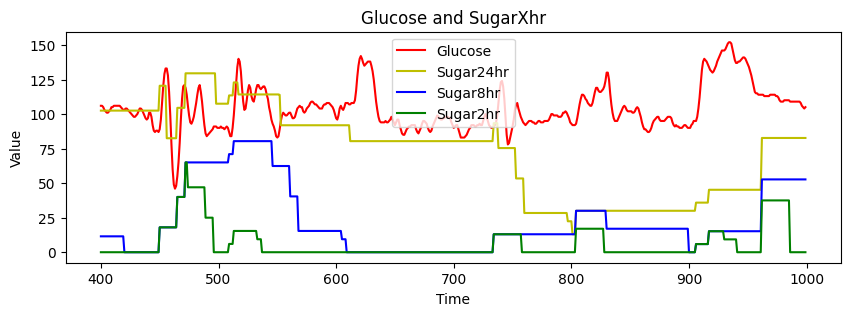

In [12]:
import matplotlib.pyplot as plt

# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['glucose'], 'r', label='Glucose')
plt.plot(filtered_df.index, filtered_df['sugar24hr'], 'y', label='Sugar24hr')
plt.plot(filtered_df.index, filtered_df['sugar8hr'], 'b', label='Sugar8hr')
plt.plot(filtered_df.index, filtered_df['sugar2hr'], 'g', label='Sugar2hr')

plt.title('Glucose and SugarXhr')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

In [13]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')

In [14]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [15]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [16]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
WakeTime          0
label             0
Length: 72, dtype: int64

In [17]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [18]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [19]:
corrdf = df.drop(columns=['datetime']).corr()

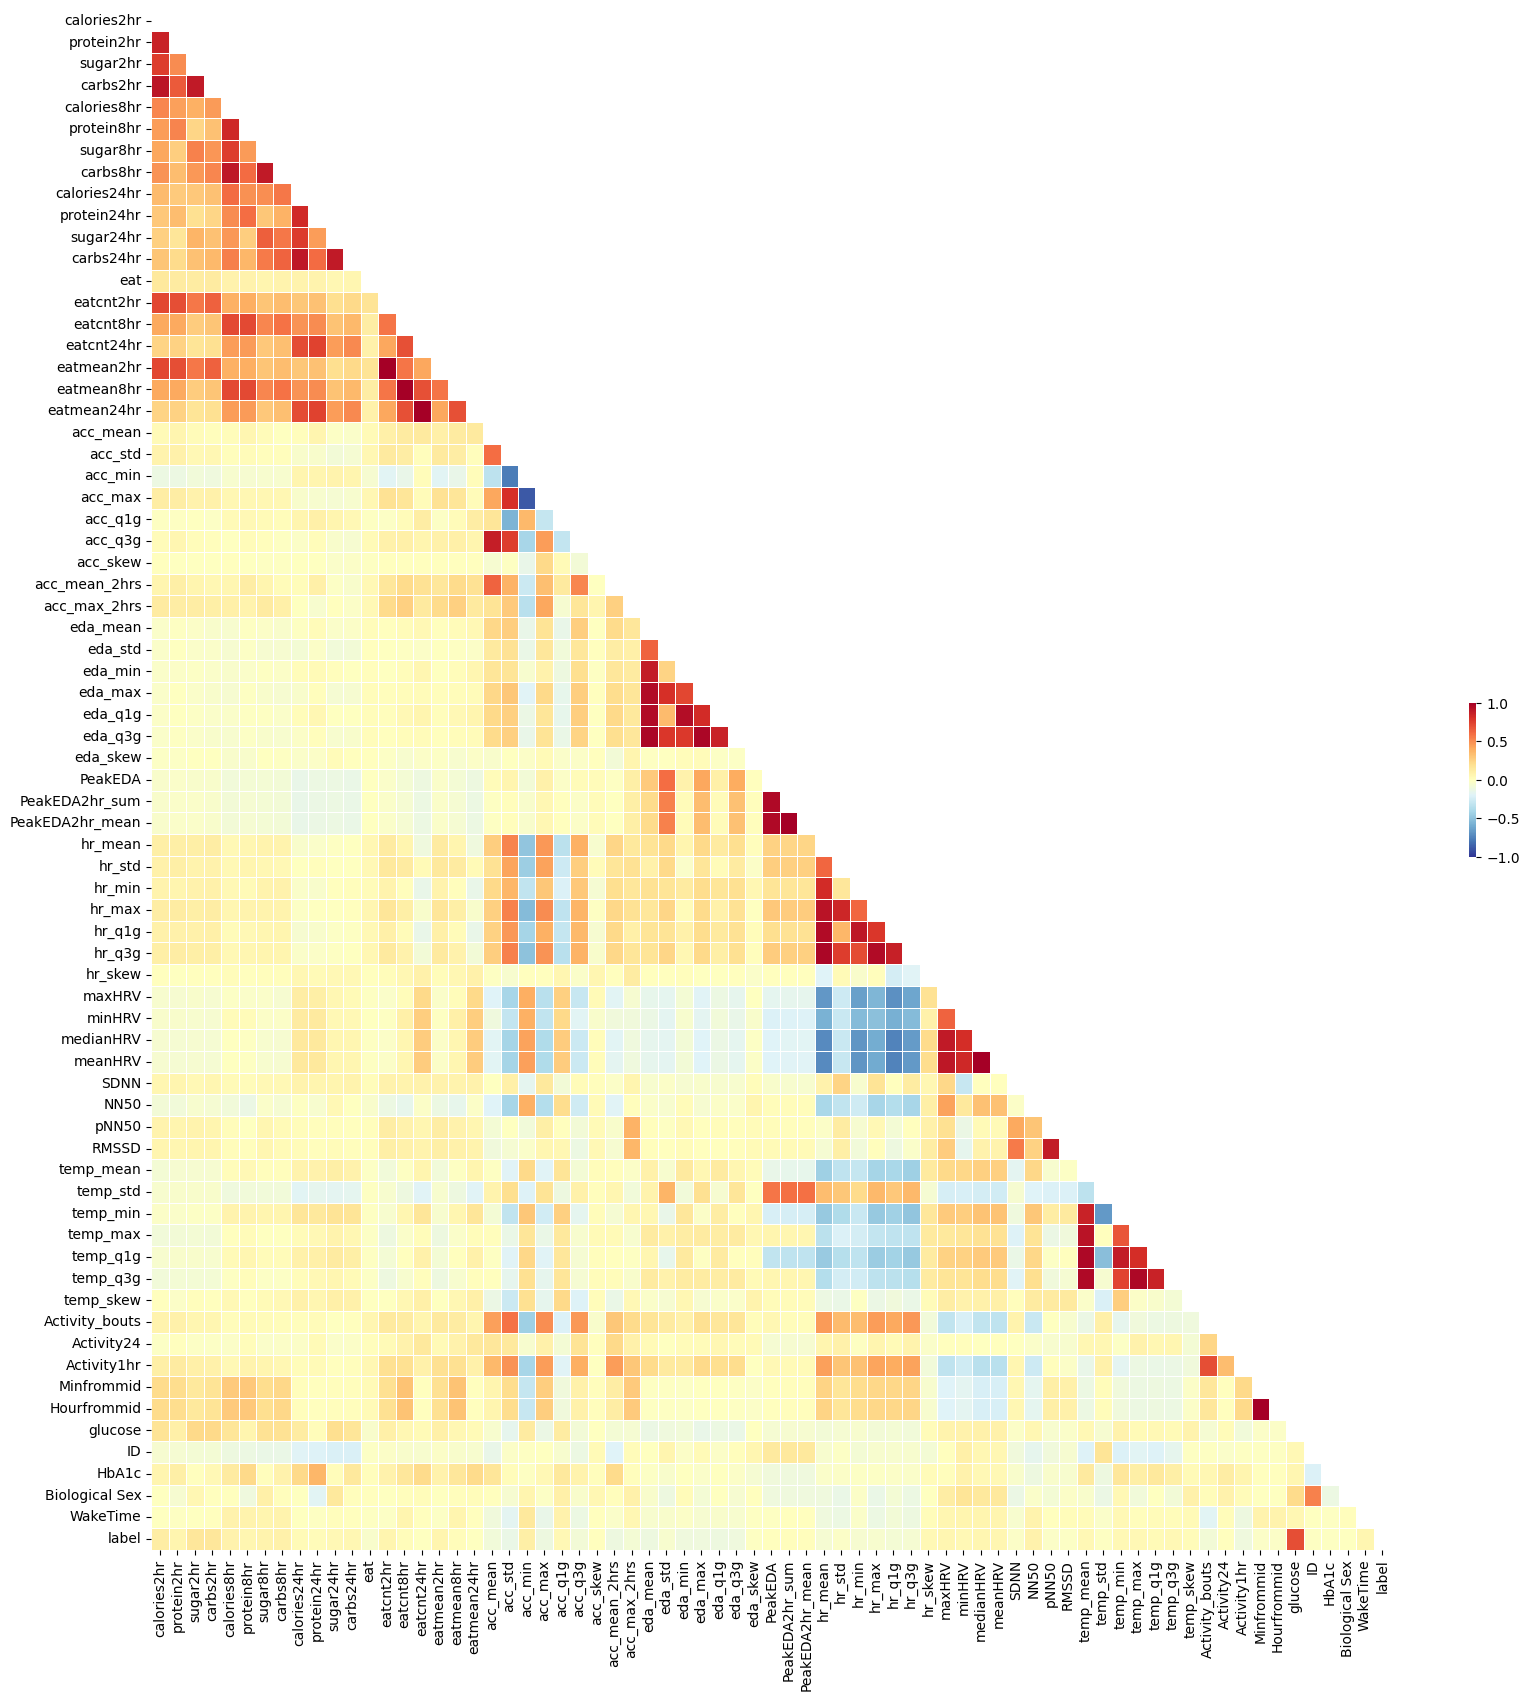

In [20]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [34]:
#lightGBM classifier 추가한 부분
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 데이터 불러오기
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

# 결측값 제거 및 데이터 타입 변환
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh': 2})

# 변수와 라벨 분리 (glucose 제외)
X = df.drop(columns=['datetime', 'label', 'glucose'])
y = df['label']

# LightGBM 파라미터 설정
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Repeated Stratified K-Fold Cross Validation 설정
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)
    
    # 모델 훈련
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
    
    # 예측
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)
    
    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred_max) * 100
    precision = precision_score(y_test, y_pred_max, average='weighted') * 100
    recall = recall_score(y_test, y_pred_max, average='weighted') * 100
    f1 = f1_score(y_test, y_pred_max, average='weighted') * 100
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# 평균 성능 출력
print(f'Average Accuracy: {np.mean(accuracy_list):.2f}% ± {np.std(accuracy_list):.2f}%')
print(f'Average Precision: {np.mean(precision_list):.2f}% ± {np.std(precision_list):.2f}%')
print(f'Average Recall: {np.mean(recall_list):.2f}% ± {np.std(recall_list):.2f}%')
print(f'Average F1 Score: {np.mean(f1_list):.2f}% ± {np.std(f1_list):.2f}%')

# 최종 모델 훈련 (glucose 제외)
train_data = lgb.Dataset(X, label=y, free_raw_data=False)
bst = lgb.train(params, train_data, num_round)

# 최종 예측
y_pred = bst.predict(X, num_iteration=bst.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y, y_pred_max) * 100
precision = precision_score(y, y_pred_max, average='weighted') * 100
recall = recall_score(y, y_pred_max, average='weighted') * 100
f1 = f1_score(y, y_pred_max, average='weighted') * 100
cm = confusion_matrix(y, y_pred_max)

print(f'Final Model Accuracy: {accuracy:.2f}%')
print(f'Final Model Precision: {precision:.2f}%')
print(f'Final Model Recall: {recall:.2f}%')
print(f'Final Model F1 Score: {f1:.2f}%')
print('Confusion Matrix:')
print(cm)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13892
[LightGBM] [Info] Number of data points in the train set: 27054, number of used features: 69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.988962
[LightGBM] [Info] Start training from score -0.340895
[LightGBM] [Info] Start training from score -1.883682
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13888
[LightGBM] [Info] Number of data points in the train set: 27055, number of used features: 69
[LightGBM] [Warnin

In [35]:
print(f'Final Model Accuracy: {accuracy:.2f}%')
print(f'Final Model Precision: {precision:.2f}%')
print(f'Final Model Recall: {recall:.2f}%')
print(f'Final Model F1 Score: {f1:.2f}%')
print('Confusion Matrix:')

Final Model Accuracy: 84.18%
Final Model Precision: 85.18%
Final Model Recall: 84.18%
Final Model F1 Score: 82.44%
Confusion Matrix:


In [144]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error

def lopocvRFC(df, groupcol, targetcol, dropcols, fs = 0.005):
    logo = LeaveOneGroupOut()
    clf = RandomForestClassifier(n_estimators=100, random_state=0)

    X = df.drop(columns=[targetcol])
    X = X.drop(columns=dropcols)
    y = df[targetcol]
    groups = np.array(df[groupcol])

    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])

    # RMSE와 MAPE를 저장할 리스트 초기화
    rmse_list = []
    mape_list = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        print(f'Group {groups[test_index][0]} - Accuracy: {accuracy_score(y_test, y_pred)}')

        # RMSE와 MAPE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse_list.append(rmse)
        mape_list.append(mape)

        feature_list = list(X_train.columns)
    
        # Feature importances를 데이터프레임에 추가
        temp_df = pd.DataFrame({
            'value': [feature_list[i] for i in range(X.shape[1])],
            'importances': clf.feature_importances_,
            'id': groups[test_index][0]  # 테스트 그룹의 ID 추가
        })
        
        importances_df = pd.concat([importances_df, temp_df], ignore_index=True)
    
    # RMSE와 MAPE의 평균 및 표준 편차 계산 및 출력
    mean_rmse = np.mean(rmse_list)
    std_rmse = np.std(rmse_list)
    mean_mape = np.mean(mape_list)
    std_mape = np.std(mape_list)

    print('Mean RMSE:' + str(mean_rmse))
    print('Std RMSE:' + str(std_rmse))
    print('Mean MAPE:' + str(mean_mape))
    print('Std MAPE:' + str(std_mape))

    # 평균 feature importance 계산
    mean_importances = importances_df.groupby('value')['importances'].mean().sort_values(ascending=False).reset_index()

    return mean_rmse, std_rmse, mean_mape, std_mape, mean_importances
'''

"\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import LeaveOneGroupOut\nfrom sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error\n\ndef lopocvRFC(df, groupcol, targetcol, dropcols, fs = 0.005):\n    logo = LeaveOneGroupOut()\n    clf = RandomForestClassifier(n_estimators=100, random_state=0)\n\n    X = df.drop(columns=[targetcol])\n    X = X.drop(columns=dropcols)\n    y = df[targetcol]\n    groups = np.array(df[groupcol])\n\n    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])\n\n    # RMSE와 MAPE를 저장할 리스트 초기화\n    rmse_list = []\n    mape_list = []\n\n    for train_index, test_index in logo.split(X, y, groups):\n        X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n        y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n        clf.fit(X_train, y_train.values.ravel())\n        y_pred = clf.predict(X_test)\n        print(f'Group {groups[test_index][0]} - Accuracy: 

In [145]:
'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error

def lopocvRFR(df, groupcol, targetcol, dropcols, fs = 0.005):
    logo = LeaveOneGroupOut()
    reg = RandomForestRegressor(n_estimators=100, random_state=0)

    X = df.drop(columns=[targetcol])
    X = X.drop(columns=dropcols)
    y = df[targetcol]
    groups = np.array(df[groupcol])

    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])

    # RMSE와 MAPE를 저장할 리스트 초기화
    rmse_list = []
    mape_list = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reg.fit(X_train, y_train.values.ravel())
        y_pred = reg.predict(X_test)

        # RMSE와 MAPE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse_list.append(rmse)
        mape_list.append(mape)

        feature_list = list(X_train.columns)
    
        # Feature importances를 데이터프레임에 추가
        temp_df = pd.DataFrame({
            'value': [feature_list[i] for i in range(X.shape[1])],
            'importances': reg.feature_importances_,
            'id': groups[test_index][0]  # 테스트 그룹의 ID 추가
        })
        
        importances_df = pd.concat([importances_df, temp_df], ignore_index=True)

        print(f'ID : {groups[test_index][0]} ... done')
    
    # RMSE와 MAPE의 평균 및 표준 편차 계산 및 출력
    mean_rmse = np.mean(rmse_list)
    std_rmse = np.std(rmse_list)
    mean_mape = np.mean(mape_list)
    std_mape = np.std(mape_list)

    print('Mean RMSE:' + str(mean_rmse))
    print('Std RMSE:' + str(std_rmse))
    print('Mean MAPE:' + str(mean_mape))
    print('Std MAPE:' + str(std_mape))

    # 평균 feature importance 계산
    mean_importances = importances_df.groupby('value')['importances'].mean().sort_values(ascending=False).reset_index()

    return mean_rmse, std_rmse, mean_mape, std_mape, mean_importances
'''

"\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import LeaveOneGroupOut\nfrom sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error\n\ndef lopocvRFR(df, groupcol, targetcol, dropcols, fs = 0.005):\n    logo = LeaveOneGroupOut()\n    reg = RandomForestRegressor(n_estimators=100, random_state=0)\n\n    X = df.drop(columns=[targetcol])\n    X = X.drop(columns=dropcols)\n    y = df[targetcol]\n    groups = np.array(df[groupcol])\n\n    importances_df = pd.DataFrame(columns=['value', 'importances', 'id'])\n\n    # RMSE와 MAPE를 저장할 리스트 초기화\n    rmse_list = []\n    mape_list = []\n\n    for train_index, test_index in logo.split(X, y, groups):\n        X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n        y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n        reg.fit(X_train, y_train.values.ravel())\n        y_pred = reg.predict(X_test)\n\n        # RMSE와 MAPE 계산\n        rmse = np.sqrt(mean_squar

### Leave-one-person-out cross validation Random forest regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [146]:
#meanrmse, stdrmse, meanmape, stdmape, importances_reg = lopocvRFR(df, 'ID', 'glucose', ['label', 'datetime'], fs=0.005)

In [147]:
#importances_reg.head(15)

In [148]:
'''


# 막대그래프로 중요도 출력
plt.figure(figsize=(15, 6))
plt.bar(importances_reg['value'], importances_reg['importances'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임
plt.tight_layout()  # 그래프 간격 조정
plt.show()
'''

"\n\n\n# 막대그래프로 중요도 출력\nplt.figure(figsize=(15, 6))\nplt.bar(importances_reg['value'], importances_reg['importances'])\nplt.xlabel('Feature')\nplt.ylabel('Importance')\nplt.title('Feature Importance')\nplt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임\nplt.tight_layout()  # 그래프 간격 조정\nplt.show()\n"

In [149]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features 
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RFLOOCV')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return errors, RMSE, MAPerror, important

def loocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        er, rm, ma, imp= RFLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [150]:
errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.02)

IDlist : ['13.0', '3.0', '10.0', '4.0', '6.0', '11.0', '12.0', '16.0', '1.0', '9.0', '15.0', '5.0', '14.0', '2.0', '8.0']
28372
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


c:\Users\이경주\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
28047
2014
Now processing... LOOCV_featureselection


In [ ]:
print(importances)

               value  importances    id
0           sugar2hr     0.044074   4.0
1           carbs2hr     0.094108   4.0
2         protein8hr     0.063440   4.0
3           carbs8hr     0.083610   4.0
4          sugar24hr     0.080125   4.0
..               ...          ...   ...
202  PeakEDA2hr_mean     0.042167  13.0
203          meanHRV     0.071181  13.0
204       Activity24     0.087457  13.0
205       Minfrommid     0.138622  13.0
206            HbA1c     0.046703  13.0

[207 rows x 3 columns]


                 importances
value                       
Minfrommid          0.177758
Activity24          0.108786
acc_mean_2hrs       0.091045
acc_max_2hrs        0.083700
meanHRV             0.071181
carbs2hr            0.068111
HbA1c               0.066074
acc_std             0.061460
carbs8hr            0.060875
sugar2hr            0.057821
sugar24hr           0.057625
protein8hr          0.052821
carbs24hr           0.048480
protein24hr         0.048113
Biological Sex      0.047536
PeakEDA2hr_sum      0.045057
PeakEDA2hr_mean     0.043560
sugar8hr            0.042523
calories8hr         0.040513
calories24hr        0.034767


C:\Users\이경주\AppData\Local\Temp\ipykernel_21108\2296911451.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


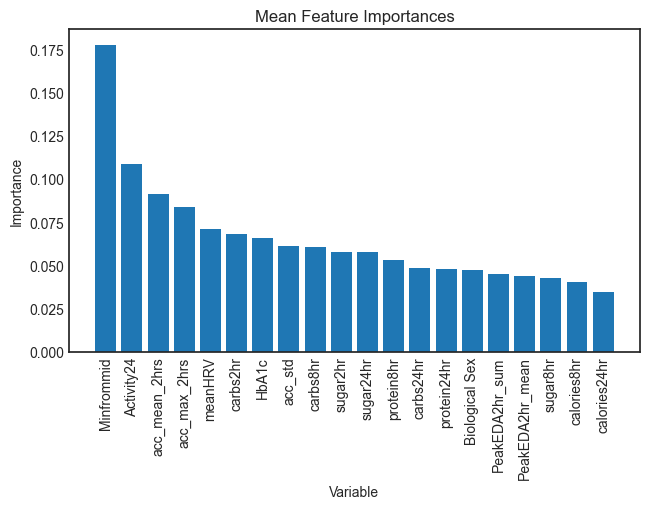

In [ ]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
print(filteredimp)
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()